In [1]:
from skimage import io
from PIL.PngImagePlugin import PngImageFile
import scipy.ndimage as ndimage
import numpy as np
import cv2
from skimage import measure, morphology, segmentation
import matplotlib.pyplot as plt
import os
import re

For patient: Novara 3
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I45
0
4095
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I55
0
4095
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I65
0
2828
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I75
0
2796
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I85
0
2666
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I95
0
2765
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I105
0
2716
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I115
0
2811
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I125
0
2776
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I135
0
2745
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I145
0
2788
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I155
0
2679
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I165
0
2598
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I175
0
2678
D:/Sem8/Novara 3/Novara 3 Lung/DICOM/I185
0
2706


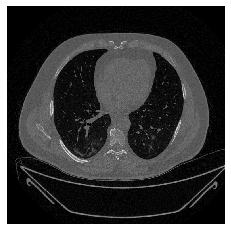

In [2]:
import re
import pydicom as dicom
import PIL
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

def normal(an_array):
  norm = np.linalg.norm(an_array)
  normal_array = an_array/norm
  return (normal_array)

def get_pixels_hu(scans):
    image = np.stack(scans.pixel_array)
    image = image.astype(np.int16)
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0 
    # Convert to Hounsfield units (HU)
    intercept = scans.RescaleIntercept
    slope = scans.RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    return np.array(image, dtype=np.int16)

#name = your list of patient names
name = ['Novara 3'] #,'Novara 2','Novara 133','Novara 134','Novara 135','Novara 136','Novara 137','Novara 139','Novara 142']
min_slice = 45
max_slice = 185
for i in name:
  print("For patient: " + i)
  #image_dir_path = 'path for the dicom directory according to the below mentioned format where i is the name of the patient'
  image_dir_path = 'D:/Sem8/' + i + '/' + i + ' Lung/DICOM'
  image_dir = sorted_alphanumeric(os.listdir(image_dir_path))
  #save_dir_path = 'path to save the output files according to the below mentioned format where i is the name of the patient'
  save_dir_path = 'D:/Sem8/' + i + '/(1) JPG/'
  
  for slices in range(min_slice,max_slice + 1,10):
    image_path = image_dir_path +'/'+ image_dir[slices]
    print(image_path)
    ds = dicom.dcmread(image_path)
    an_array = get_pixels_hu(ds)
    plt.axis('off')
    plt.gray() 
    an_array = ds.pixel_array
    print(ds.pixel_array.min())
    print(ds.pixel_array.max())
    norm = np.linalg.norm(an_array, ord='nuc')
    normal_array = an_array/norm
    plt.imshow(normal_array)
    
    maxi =str(an_array.max())
    mini =str(an_array.min())
                                          
    plt.imsave(save_dir_path +'m2-'+ i + '-Slice' + str(slices) + '.png', arr=an_array, format='png')


In [3]:
def to_rgb(im):
    # as 1, but we use broadcasting in one line
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, :] = im[:, :, np.newaxis]
    return ret

In [4]:
def generate_markers(image):
  #Creation of rough mask
    mask_rough = (image - image.min())/(image.max() - image.min())
    th, mask_rough = cv2.threshold(mask_rough,0.2 , 1, cv2.THRESH_BINARY)
    mask_rough = np.invert(mask_rough.astype(int))
    image = mask_rough
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((768,768), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    return marker_internal, marker_external, marker_watershed, mask_rough

In [5]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed, mask_rough  = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)

    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    overlay = np.where(lungfilter != 1, image, image.max())

    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, 2000*np.ones((768,768)))
    
    normalized = np.copy(segmented)
    normalized[np.where(normalized > -800)] += 200
    
    #mask_clean = lungfilter

    return segmented, lungfilter, overlay, mask_rough, normalized #lungfilter = mask_clean
    

In [ ]:
from numpy import asarray
def saving(name_patient,images,image,image_path):
    segmented, mask_clean, overlay , mask_rough, normalized = seperate_lungs(image) #lungfilter = mask_clean
    save_dir_path = 'D:/Sem8/' + name_patient

    plt.axis('off')
    plt.gray()
    plt.imsave(save_dir_path + '/(2) Mask-Rough/' + images, arr= mask_rough, format='png')

    plt.axis('off')
    plt.gray()
    plt.imsave(save_dir_path + '/(3) Mask-Clean/' + images, arr= mask_clean, format='png')

    plt.axis('off')
    plt.gray()
    plt.imsave(save_dir_path + '/(4) Segment/' + images, arr= segmented, format='png')

    plt.axis('off')
    plt.gray()
    plt.imsave(save_dir_path + '/(5) Overlay/' + images, arr= overlay, format='png')

    plt.axis('off')
    plt.gray()
    plt.imsave(save_dir_path + '/(7) Normalize/' + images, arr= normalized, format='png')

    #generating colored image
    im = cv2.imread(image_path)
    x = cv2.imread(image_path)
    blue   = [0,0,255]
    green = [0,255,0]
    red  = [255,0,0]
    black = [0,0,0]

    Rmask = np.all(im > [60,60,60], axis=-1)
    im[Rmask] = red
    Rmask = np.all(np.logical_and(im>=[25,25,25], im<=[60,60,60]), axis=-1)
    im[Rmask] = green
    Rmask = np.all(im < [25,25,25], axis=-1)
    im[Rmask] = blue
    mask_clean = to_rgb(mask_clean)
    color = np.where(mask_clean == 1, im, x)
    plt.imsave(save_dir_path + '/(6) Color/' + images, arr= color, format='png')


name = ['Novara 3']#,'Novara 2','Novara 133','Novara 134','Novara 135','Novara 136','Novara 137','Novara 139','Novara 142']

for i in name:
  print("For patient: " + i)
  #image_dir_path = 'path for the dicom directory according to the below mentioned format where i is the name of the patient'
  image_dir_path = 'D:/Sem8/' + i + '/(1) JPG/'
  image_dir_list = sorted_alphanumeric(os.listdir(image_dir_path))
  
  
  for image_name in image_dir_list:
      print(image_name)
      image_path = image_dir_path + '/' + image_name
      targetImage = PngImageFile(image_path)  
      #denormalize the image
      image = io.imread(image_path, as_gray=True)
        
      print(image.shape)
      normalizedImg = np.zeros((768, 768))
      normalizedImg = cv2.normalize(image,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
    
      cv2.imshow('Novara3_normalized', normalizedImg)
      cv2.waitKey(0)
      cv2.destroyAllWindows()
        
      saving(i,image_name,image,image_path)
      
      

For patient: Novara 3
m2-Novara 3-Slice45.png
(768, 768)
m2-Novara 3-Slice55.png
(768, 768)
m2-Novara 3-Slice65.png
(768, 768)
m2-Novara 3-Slice75.png
(768, 768)
